In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data,
    mean_min_loss,
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
n_dimensions = 2
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1
rng = np.random.default_rng(random_seed)

In [4]:
# generate training data
def f_1(x):
    A = -1.5
    B = np.array([[4], [0]])
    C = np.array([[0], [0]])
    D = np.array([[-2], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = -1.5
    B = np.array([[0], [4]])
    C = np.array([[0], [0]])
    D = np.array([[0], [-2]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x)]))
    return drift


def sigma_11(x):
    A = 0.5  
    B = np.array([[0.05], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = 0
    B = np.array([[0], [0]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = 0.5
    B = np.array([[0], [0.05]])
    C = np.array([[0], [0]])
    D = np.array([[0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusion(x):
    diffusion = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x)], [sigma_12(x), sigma_22(x)]])))
    return diffusion


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2], [-2, 2]])

x_data, y_data, _ = sample_data(true_drift_diffusion, step_size,
                             n_pts, n_subsample, rng, xlim)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

data shape (10000, 2)


In [5]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**8, 
                                M_min=50,
                                M_max=300,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=0.1,
                               name='diff')


In [6]:
# calculate theoretical mean min loss (integral over loss function)
mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim)


Theoretical mean min loss: -3.167083934678069
Loss standard deviation: 0.010540925533894598
Validation loss standard deviation: 0.03162277660168379


drift epoch: 60


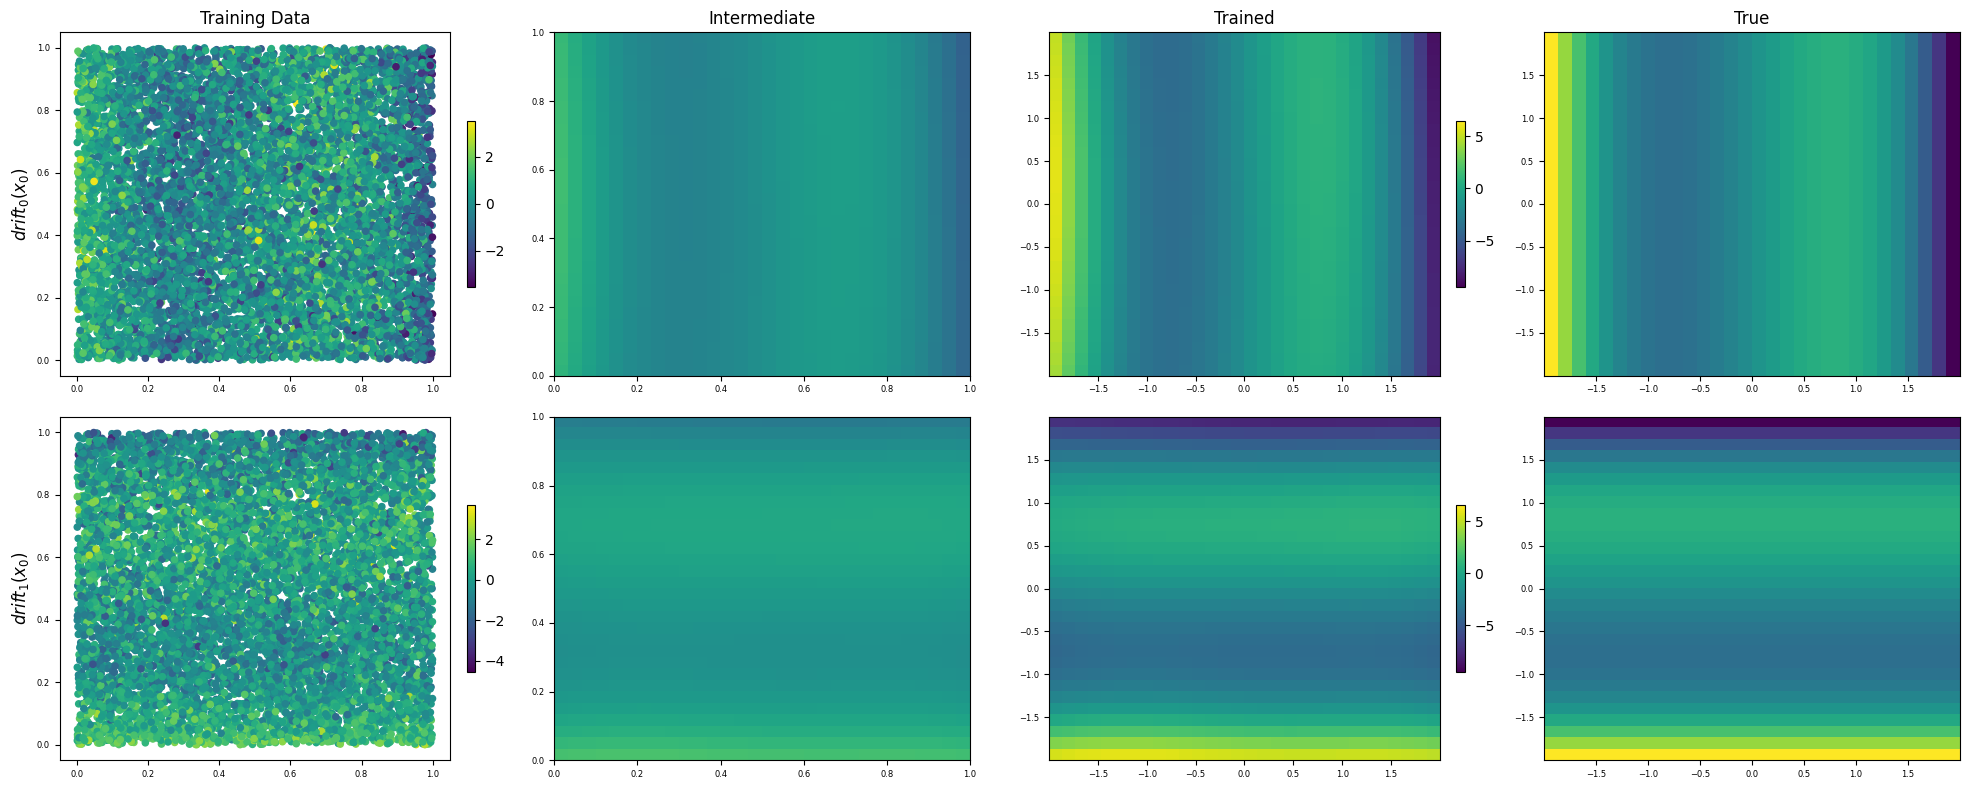

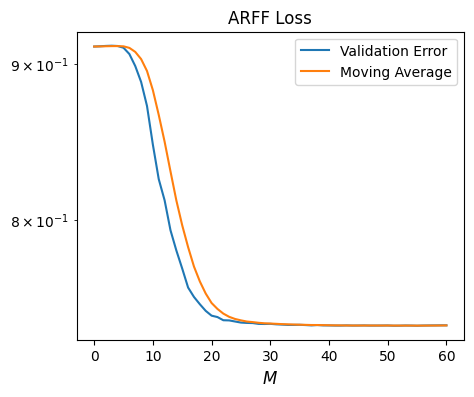

diff epoch: 50


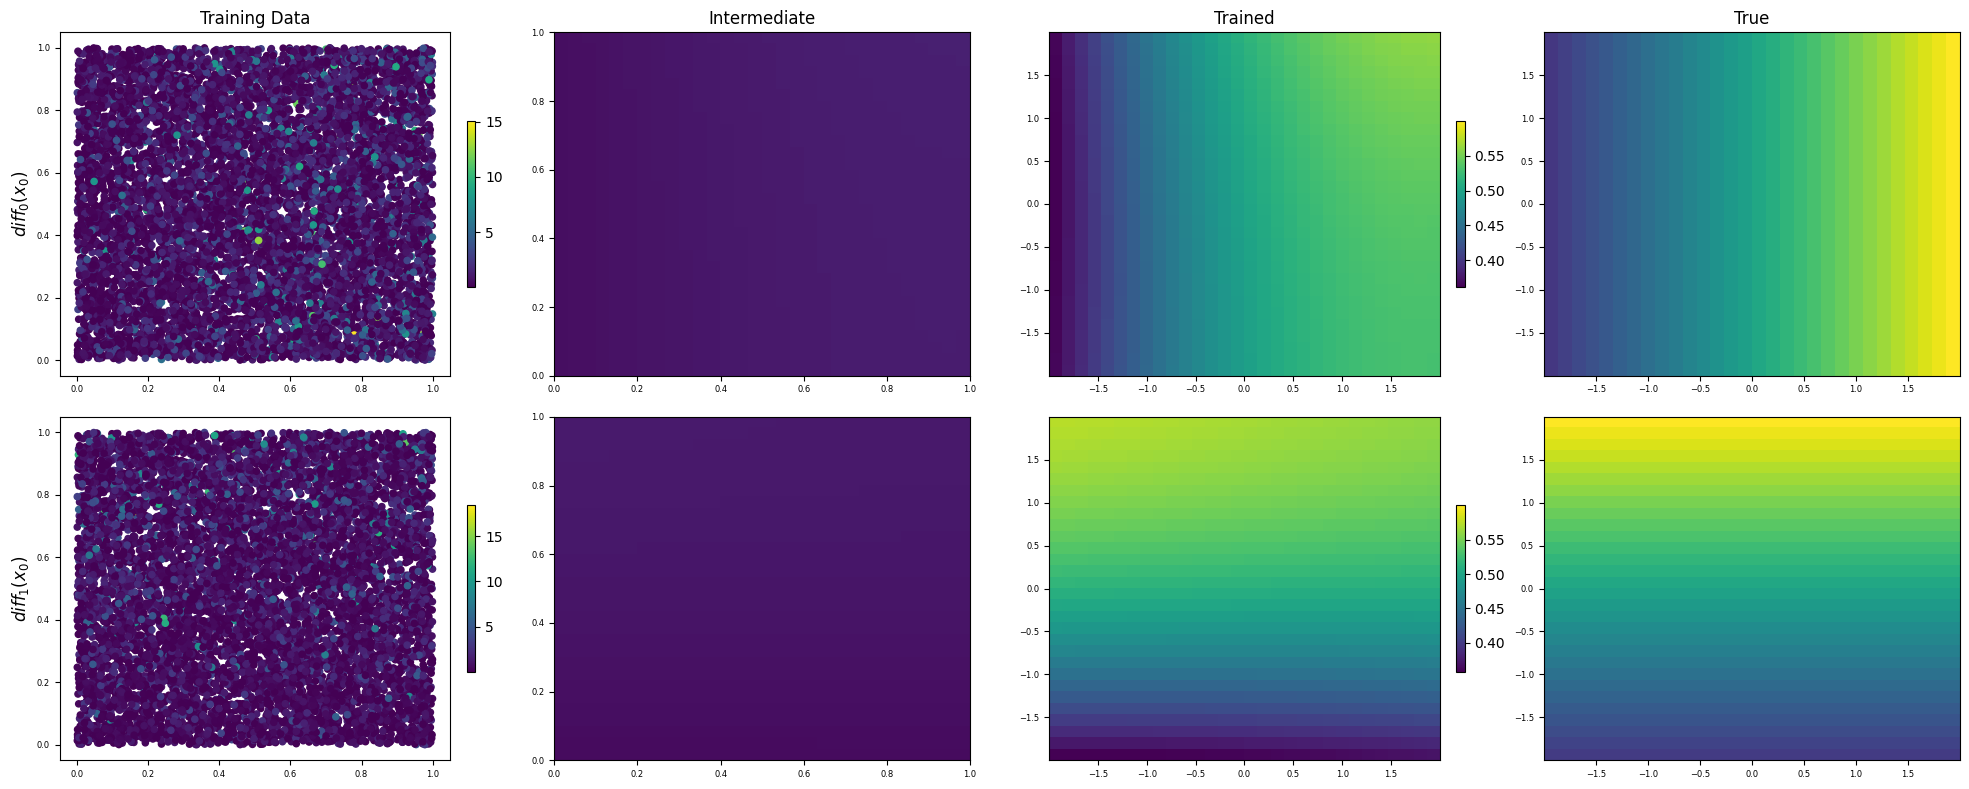

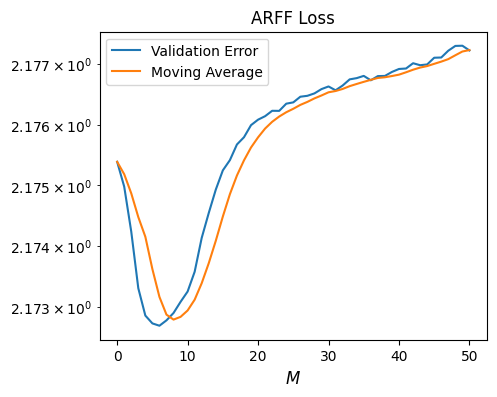

Observed loss: -3.2057875310016417
Observed validation loss: -3.1959766023506444
True function validation loss: -3.1918664077811463
Training time: 18.924453735351562


In [7]:
# training
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

figures_per_row 2


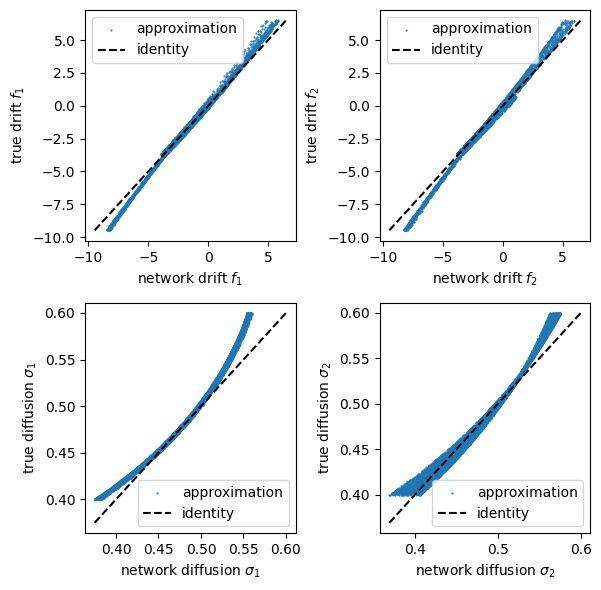

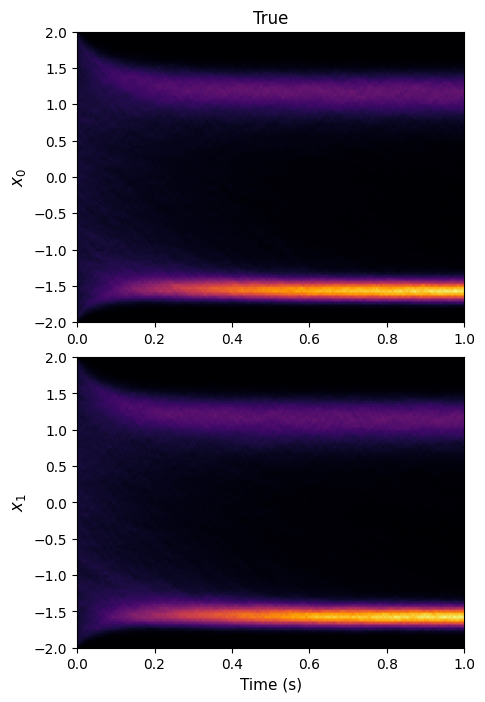

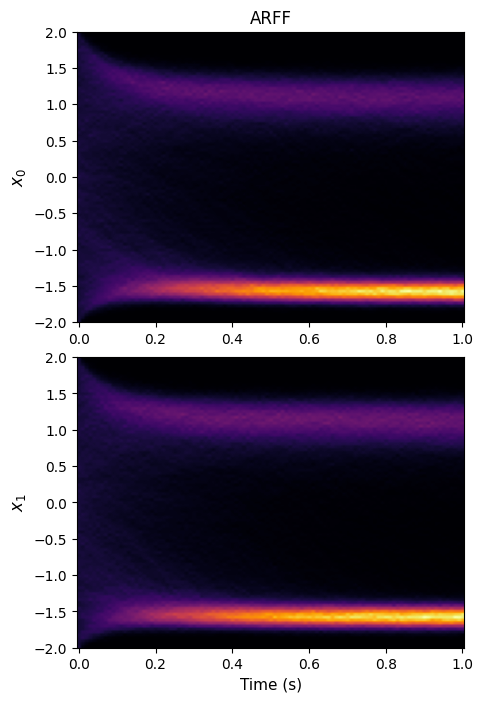

In [7]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=False)

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='ARFF', save=False)
